In [515]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [516]:
X = torch.tensor([i for i in range(-30, 30)]).float()

In [517]:
def randvec(r1, r2, shape):
    return (r1 - r2) * torch.rand(shape) + r2

In [518]:
y = randvec(-1e4, 1e4, X.shape) - (1/2) * X + 3 * X.pow(2) - (6/4) * X.pow(3)

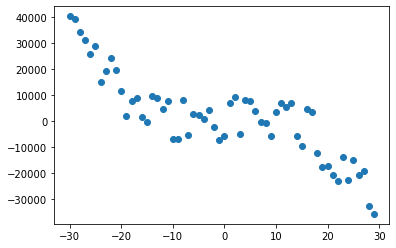

In [519]:
plt.scatter(X, y)

In [520]:
def mse(y_true, y_pred):
    e = y_true - y_pred
    return e.T.mm(e) / y_true.shape[0]

In [521]:
def create_features(X, degree=2, standardize=True):
    if len(X.shape) == 1:
        X = X.unsqueeze(1)
    ones_col = torch.ones((X.shape[0], 1), dtype=torch.float32)
    X_d = torch.cat([ones_col, X], axis=1)
    for i in range(1, degree):
        X_pow = X.pow(i + 1)
        if standardize:
            X_pow -= X_pow.mean()
            std = X_pow.std()
            if std != 0:
                X_pow /= std
        X_d = torch.cat([X_d, X_pow], axis=1)
    return X_d

In [522]:
features = create_features(X, degree=3, standardize=False)

In [523]:
def get_weights_col(X):
    return torch.ones(X.shape[1], 1)

In [524]:
def predict(features, weights):
    return features.mm(weights)

In [525]:
y_true = y.unsqueeze(1)

In [526]:
def normal_equation(y_true, X):
    XTX_inv = (X.T.mm(X)).inverse()
    XTy = X.T.mm(y_true)
    weights = XTX_inv.mm(XTy)
    return weights

In [527]:
weights = normal_equation(y_true, features)

In [528]:
y_pred = predict(features, weights)

In [529]:
print(mse(y_true, y_pred))

tensor([[31267848.]])


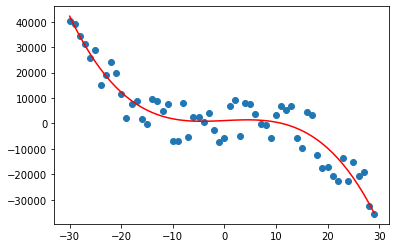

In [530]:
plt.scatter(X, y)
plt.plot(X, y_pred, c='red')

In [531]:
def gradient_descent(X, y_true, lr=0.001, it=30000):
    weights_gd = torch.ones((X.shape[1], 1))
    n = X.shape[0]
    fact = 2 / n
    for _ in range(it):
        y_pred = predict(X, weights_gd)
        grad = fact * X.T.mm(y_pred - y_true)
        weights_gd -= lr * grad
    return weights_gd

In [532]:
features = create_features(X, degree=3, standardize=True)
weights_gd = gradient_descent(features, y_true)

In [533]:
pred_gd = predict(features, weights_gd)

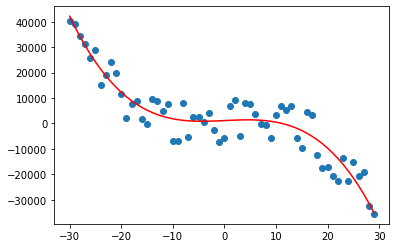

In [534]:
plt.scatter(X, y)
plt.plot(X, pred_gd, c='red')